In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init
import sys

sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel
import random
from torch.autograd import Variable

In [2]:
import random
from torch.autograd import Variable

In [3]:
df = pd.read_hdf("/data/t3home000/spark/LHCOlympics_previous/preprocessed_40part_testdataset.h5")

In [4]:
dt = df.values

In [5]:
dt.shape

(1100000, 121)

In [6]:
idx = dt[:,120]
bkg_idx = np.where(idx==0)[0]
sig_idx = np.where(idx==1)[0]

In [7]:
dt = dt[:,:120]
label = idx

In [8]:
dt.shape

(1100000, 120)

In [9]:
label.shape

(1100000,)

In [10]:
data = np.reshape(dt, (-1,40,3))

In [11]:
data.shape

(1100000, 40, 3)

In [12]:
label

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
data_bkg = dt[bkg_idx]

data_sig = dt[sig_idx]

data_bkg = data_bkg[:,0:120]

data_sig = data_sig[:,0:120]

data_bkg = np.reshape(data_bkg, (-1,40,3))

data_bkg.shape # (Nevents, Npfcands, Nfeats)

data_sig = np.reshape(data_sig, (-1,40,3))

data_sig.shape

(100000, 40, 3)

In [30]:
class SentenceVAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size,num_layers=2, bidirectional=False):

        super().__init__()
        self.tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
        # max_sequence_length = 40
        # latent_size, lets call it 10 or shit like that
        self.latent_size = latent_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.k, self.heads = input_size, 8


        rnn = nn.GRU
        # elif rnn_type == 'lstm':
        #     rnn = nn.LSTM

        self.encoder_rnn = rnn(input_size, hidden_size, num_layers=num_layers, bidirectional=self.bidirectional,
                               batch_first=True)
        self.decoder_rnn = rnn(input_size, hidden_size, num_layers=num_layers, bidirectional=self.bidirectional,
                               batch_first=True)
        
        k = input_size
        heads = 8
        self.tokeys    = nn.Linear(k, k * heads, bias=False)
        self.toqueries = nn.Linear(k, k * heads, bias=False)
        self.tovalues  = nn.Linear(k, k * heads, bias=False)

        # This unifies the outputs of the different heads into 
        # a single k-vector
        self.unifyheads = nn.Linear(heads * k, k)

        self.hidden_factor = (2 if bidirectional else 1) * num_layers

        self.hidden2mean = nn.Linear(hidden_size * self.hidden_factor, latent_size)
        self.hidden2logv = nn.Linear(hidden_size * self.hidden_factor, latent_size)
        self.latent2hidden = nn.Linear(latent_size, hidden_size * self.hidden_factor)
        self.latent2input = nn.Linear(latent_size, input_size*40)
        self.output2particles = nn.Linear(hidden_size, input_size)

    def forward(self, input_sequence):

        batch_size = input_sequence.size(0)

        # ENCODER


        _, hidden = self.encoder_rnn(input_sequence)

        if self.bidirectional or self.num_layers > 1:
            # flatten hidden state
            hidden = hidden.view(batch_size, self.hidden_size*self.hidden_factor)
        else:
            hidden = hidden.squeeze()

        # REPARAMETERIZATION
        mean = self.hidden2mean(hidden)
        logv = self.hidden2logv(hidden)
        std = torch.exp(0.5 * logv)

        z = torch.randn([batch_size, self.latent_size]).cuda()
        z = z * std + mean
        kld = -0.5 * torch.sum(1 + logv - mean.pow(2) - logv.exp())
        
        pseudo_input = self.latent2input(z).view(input_sequence.shape)
        
        b, t, k = pseudo_input.size()
        h = self.heads

        queries = self.toqueries(pseudo_input).view(b, t, h, k)
        keys    = self.tokeys(pseudo_input)   .view(b, t, h, k)
        values  = self.tovalues(pseudo_input) .view(b, t, h, k)
        
        
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
        values = values.transpose(1, 2).contiguous().view(b * h, t, k)

        queries = queries / (k ** (1/4))
        keys    = keys / (k ** (1/4))

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))
        # - dot has size (b*h, t, t) containing raw weights

        dot = F.softmax(dot, dim=2) 
        # - dot now contains row-wise normalized weights
        
        out = torch.bmm(dot, values).view(b, h, t, k)
        out = out.transpose(1, 2).contiguous().view(b, t, h * k)
        recons =  self.unifyheads(out)

        return pseudo_input, kld




In [31]:
data_sig.shape

(100000, 40, 3)

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda:0


'GeForce RTX 2080 Ti'

In [33]:
model = SentenceVAE(3,10,4).to(device)
#self, input_size, hidden_size, latent_size,num_layers=2, bidirectional=False):

In [34]:
lr = 1e-3
bs = 1000
optimizer = optim.Adam(model.parameters(), lr=lr)

In [35]:
tensor_sig_train = torch.tensor(data_sig) 

tensor_sig_train.shape

sig_train_iterator = utils.DataLoader(tensor_sig_train, batch_size=bs, shuffle=True)

In [36]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, x in enumerate(sig_train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.float().cuda()

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, kld = model(x)

        # reconstruction loss
        recon_loss = F.mse_loss(x_sample, x, size_average=False)


        # total loss
        loss = recon_loss + kld
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()
        
    return train_loss


In [37]:
best_train_loss = float('inf')

for e in range(1000):

    train_loss = train()

    train_loss /= len(tensor_sig_train)
    print(train_loss)
    if best_train_loss > train_loss:
        best_train_loss = train_loss
        patience_counter = 1
        print("Saving model!")
        torch.save(model.state_dict(),"/data/t3home000/spark/QUASAR/weights/seq2seq_selfattentiondec.h5")

    else:
        patience_counter += 1
        print("Not saving model!")

    if patience_counter > 5:
        print("Patience Limit Reached")
        break

289.8605540625
Saving model!
269.2670684375
Saving model!
266.19548046875
Saving model!
265.092681875
Saving model!
264.5226125
Saving model!
264.08616640625
Saving model!
263.6143671875
Saving model!
263.03471015625
Saving model!
262.29498640625
Saving model!
261.441375
Saving model!
260.61347625
Saving model!
260.07540125
Saving model!
259.84017984375
Saving model!
259.7706409375
Saving model!
259.757838125
Saving model!
259.751155
Saving model!
259.74994046875
Saving model!
259.7527146875
Not saving model!
259.7480059375
Saving model!
259.7446809375
Saving model!
259.74527828125
Not saving model!
259.751254375
Not saving model!
259.7481859375
Not saving model!
259.7380046875
Saving model!


KeyboardInterrupt: 

In [22]:
model.eval()

SentenceVAE(
  (encoder_rnn): GRU(3, 10, num_layers=2, batch_first=True)
  (decoder_rnn): GRU(3, 10, num_layers=2, batch_first=True)
  (hidden2mean): Linear(in_features=20, out_features=4, bias=True)
  (hidden2logv): Linear(in_features=20, out_features=4, bias=True)
  (latent2hidden): Linear(in_features=4, out_features=20, bias=True)
  (output2particles): Linear(in_features=10, out_features=3, bias=True)
)

In [23]:
data_sig[0:4].shape

(4, 40, 3)

In [37]:
recons, kld = model(torch.Tensor(data_sig[0:10]).cuda())

In [26]:
recons_bkg, kld = model(torch.Tensor(data_bkg[0:4]).cuda())

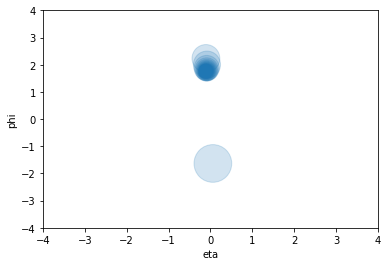

In [29]:
plot_event(recons_bkg[0].cpu().detach().numpy(),"sigAE_recons_0")

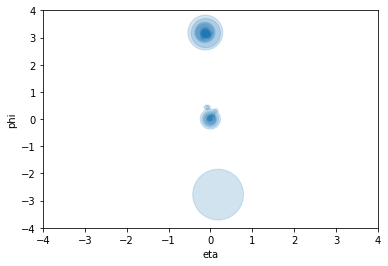

In [30]:
plot_event(data_bkg[0],"bkg_actual_0")

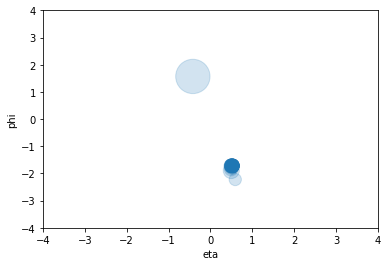

In [38]:
plot_event(recons[4].cpu().detach().numpy(),"sigAE_siginal_recons_4")

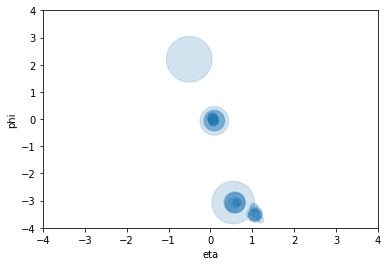

In [36]:
plot_event(data_sig[4],"sig_actual_4")

In [39]:
model_bkg = SentenceVAE(3,10,4).to(device)


In [40]:
tensor_bkg_train = torch.tensor(data_bkg) 

tensor_bkg_train.shape

bkg_train_iterator = utils.DataLoader(tensor_bkg_train, batch_size=bs, shuffle=True)

In [41]:
lr = 1e-3
bs = 1000
optimizer = optim.Adam(model_bkg.parameters(), lr=lr)

In [42]:
loss

NameError: name 'loss' is not defined

In [43]:
def train_bkg():
    # set the train mode
    model_bkg.train()

    # loss of the epoch
    train_loss = 0

    for i, x in enumerate(bkg_train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.float().cuda()

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, kld = model_bkg(x)

        # reconstruction loss
        recon_loss = F.mse_loss(x_sample, x, size_average=False)


        # total loss
        loss = recon_loss + kld
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()
        
    return train_loss


In [ ]:
best_train_loss = float('inf')

for e in range(1000):

    train_loss = train_bkg()

    train_loss /= len(tensor_bkg_train)
    print(train_loss)
    if best_train_loss > train_loss:
        best_train_loss = train_loss
        patience_counter = 1
        print("Saving model!")
        torch.save(model_bkg.state_dict(),"/data/t3home000/spark/QUASAR/weights/seq2seq_bkg.h5")

    else:
        patience_counter += 1
        print("Not saving model!")

    if patience_counter > 5:
        print("Patience Limit Reached")
        break

166.1377109375
Saving model!
127.464282109375
Saving model!
123.112391984375
Saving model!
122.618069015625
Saving model!
121.7259961484375
Saving model!


# MAKE DATASET

In [ ]:
import torch
from torch_geometric.data import InMemoryDataset, download_url

In [ ]:
class DijetAnomaly(InMemoryDataset):
    

# Make Plotting Scripts, Will later make into a separate module

In [28]:
def plot_event(pfcands, name):

    pt = pfcands[:,0]
    eta = pfcands[:,1]
    phi = pfcands[:,2]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(eta,phi,s=pt*10000, alpha=0.2)
    ax.set_xlabel('eta')
    ax.set_ylabel('phi')
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])
    fig.savefig(f'figures/{name}.png')

In [ ]:
plot_event(data_sig[4],"event_sig_idx4")

# 40 Body System, 3 features ( pT, eta, Phi) for each object (PF candidate)

In [ ]:
n_objects  = 40 # number of PF candidates(nodes)
object_dim = 3 # features: mass, x coordinate, y coordinate, speed on x-axis, speed on y-axis

n_relations  = n_objects * (n_objects - 1) # number of edges in fully connected graph
relation_dim = 1

effect_dim = 10 #effect's vector size


In [ ]:
n_relations

In [ ]:
data.shape

In [ ]:
def get_batch(data, label, idx, batch_size):
    
    start_idx = idx*batch_size
    end_idx = idx*batch_size+batch_size

    batch_data = data[start_idx: end_idx]
    label_data = label[start_idx: end_idx]
    
    objects = batch_data
    
    
    #receiver_relations, sender_relations - onehot encoding matrices
    #each column indicates the receiver and sender object’s index
    
    receiver_relations = np.zeros((batch_size, n_objects, n_relations), dtype=float);
    sender_relations   = np.zeros((batch_size, n_objects, n_relations), dtype=float);
    
    cnt = 0
    for i in range(n_objects):
        for j in range(n_objects):
            if(i != j):
                receiver_relations[:, i, cnt] = 1.0
                sender_relations[:, j, cnt]   = 1.0
                cnt += 1
    
    #There is no relation info in solar system task, just fill with zeros
    relation_info = np.zeros((batch_size, n_relations, relation_dim))
    target = label_data
    
    objects            = Variable(torch.FloatTensor(objects))
    sender_relations   = Variable(torch.FloatTensor(sender_relations))
    receiver_relations = Variable(torch.FloatTensor(receiver_relations))
    relation_info      = Variable(torch.FloatTensor(relation_info))
    target             = Variable(torch.FloatTensor(target))
                       
    if USE_CUDA:
        objects            = objects.cuda()
        sender_relations   = sender_relations.cuda()
        receiver_relations = receiver_relations.cuda()
        relation_info      = relation_info.cuda()
        target             = target.cuda()
    
    return objects, sender_relations, receiver_relations, relation_info, target


In [ ]:
class RelationalModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RelationalModel, self).__init__()
        
        self.output_size = output_size
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
        )
    
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_relations, input_size]
        Returns:
            [batch_size, n_relations, output_size]
        '''
        batch_size, n_relations, input_size = x.size()
        x = x.view(-1, input_size)
        x = self.layers(x)
        x = x.view(batch_size, n_relations, self.output_size)
        return x

In [ ]:
class ObjectModel(nn.Module):
    def __init__(self, input_size, hidden_size, D):
        super(ObjectModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1), #speedX and speedY
        )
        
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_objects, input_size]
        Returns:
            [batch_size * n_objects, 2] speedX and speedY
        '''
        input_size = x.size(2)*x.size(1)
        x = x.view(-1, input_size)
        return self.layers(x)


In [ ]:
class InteractionNetwork(nn.Module):
    def __init__(self, n_objects, object_dim, n_relations, relation_dim, effect_dim):
        super(InteractionNetwork, self).__init__()
        
        self.relational_model = RelationalModel(2*object_dim + relation_dim, effect_dim, 150)
        self.object_model     = ObjectModel((object_dim + effect_dim)*n_objects, 100)
    
    def forward(self, objects, sender_relations, receiver_relations, relation_info):
        senders   = sender_relations.permute(0, 2, 1).bmm(objects)
        receivers = receiver_relations.permute(0, 2, 1).bmm(objects)
        effects = self.relational_model(torch.cat([senders, receivers, relation_info], 2))
        effect_receivers = receiver_relations.bmm(effects)
        predicted = self.object_model(torch.cat([objects, effect_receivers], 2))
        return predicted

In [ ]:
USE_CUDA = True

In [ ]:
interaction_network = InteractionNetwork(n_objects, object_dim, n_relations, relation_dim, effect_dim)

if USE_CUDA:
    interaction_network = interaction_network.cuda()
    
optimizer = optim.Adam(interaction_network.parameters())
criterion = nn.BCEWithLogitsLoss()



In [ ]:
n_epoch = 100
batch_size=1000
batches_per_epoch = int(len(data)/batch_size)

losses = []
for epoch in range(n_epoch):
    for idx in range(batches_per_epoch):
        print((idx/batches_per_epoch)*100,"percent")
        objects, sender_relations, receiver_relations, relation_info, target = get_batch(data, label, idx, batch_size)
        predicted = interaction_network(objects, sender_relations, receiver_relations, relation_info)
        loss = criterion(predicted.flatten(), target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.cpu().numpy())
        
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Epoch %s RMS Error %s' % (epoch, np.sqrt(np.mean(losses[-100:]))))
    plt.plot(losses)
    plt.show()